## 1 导入工具包

该场景案例的主要内容是树回归算法分析房价趋势，用到的主要框架包括：

1. Numpy：Numpy是一个运行速度非常快的数学库，支持大量的维度数组与矩阵运算,主要用于数组计算；

2. Pandas：Pandas是python的一个数据分析包，主要用于数据挖掘与分析，功能强大；

3. sklearn-learn: 专门用于机器学习的模块，主要有分类，回归，无监督，数据降维，数据预处理等功能，包含了常见的大部分机器学习方法；

4. Scipy: 一个高级的科学计算库，是一款方便、易于使用、专为科学和工程设计的python工具包；

5. matplotlib、seaborn: python中最常使用的绘图工具包，可以很好地将实验效果可视化展现；

6. warnings，主要用于代码运行中忽略警告。

In [3]:
# 导入需要的模块
import pandas as pd    
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# 忽略警告
warnings.filterwarnings('ignore') 
# 使用 ggplot 画图风格
plt.style.use('ggplot')
%matplotlib inline

In [5]:
# 读取数据，index_col=0表示以第一列为索引
data = pd.read_csv('./train.csv', index_col=0)

In [6]:
# 查看数据维度
data.shape

(1460, 80)

In [7]:
# 查看数据前五行
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
# 查看数据特征类型, 即除SalePrice的列，有数值类型(numerical)和类别类型（category）
# 统计数值类型(numerical)特征名，保存为列表
numeric=[f for f in data.drop(['SalePrice'],axis=1).columns 
         if data.drop(['SalePrice'],axis=1).dtypes[f]!='object']
# 统计类别类型（category）特征名，保存为列表
category=[f for f in data.drop(['SalePrice'],axis=1).columns 
          if data.drop(['SalePrice'],axis=1).dtypes[f]=='object']
# 输出数值类型(numerical)特征个数，类型（category）特征个数
print("numeric: {}, category: {}" .format (len(numeric),len(category)))

numeric: 36, category: 43


In [10]:
# 统计每个特征的缺失数
missing = data.isnull().sum()
# 将缺失数从大到小排序
missing.sort_values(inplace=True,ascending=False)
# 选取缺失数大于0的特征
missing = missing[missing > 0]
# 保存含缺失值特征的类型
types = data[missing.index].dtypes
# 计算缺失值百分比
percent = missing / data.shape[0]
# 将缺失值信息整合
missing_data = pd.concat([missing, percent,types],axis=1,
                         keys=['Total', 'Percent','Types'])
# 输出缺失值信息
missing_data

,Total,Percent,Types
PoolQC,1453,0.995205,object
MiscFeature,1406,0.963014,object
Alley,1369,0.937671,object
Fence,1179,0.807534,object
MasVnrType,872,0.597260,object
FireplaceQu,690,0.472603,object
LotFrontage,259,0.177397,float64
GarageYrBlt,81,0.055479,float64
GarageCond,81,0.055479,object
GarageType,81,0.055479,object


In [11]:
# 缺失值处理
# 对缺失值超过15%的特征进行删除
data.drop(missing_data[missing_data['Percent'] > 0.15].
          index, axis=1, inplace=True)
# 输出数据维度
print(data.shape)

(1460, 73)


In [12]:
# 对于部分 类别型数据，其空值可用众数进行填充，如 Electrical
data['Electrical'].fillna(data['Electrical'].mode()[0], inplace=True)

In [18]:
# 由data_description里面的内容的可知，对于部分 类别型数据，
#对应的的空值表示没有该项设施，则空值可以用‘None’填充,即将空值视为新的类别
cols1 = ['GarageFinish', 'GarageQual', 'GarageType', 'GarageCond', 
         'BsmtFinType2', 'BsmtExposure',
         'BsmtFinType1', 'BsmtQual', 'BsmtCond', 'MasVnrType']

# 确保只对实际存在的列操作
existing_cols = [col for col in cols1 if col in data.columns]

# 填充缺失值
data[existing_cols] = data[existing_cols].fillna('None')

# 提示缺失的列
missing_cols = [col for col in cols1 if col not in data.columns]
if missing_cols:
    print(f"These columns are not found in the DataFrame: {missing_cols}")

# # 依次便利cols1中的特征，对应缺失值用‘None’填充
# for col in cols1:
#     data[col].fillna('None', inplace=True)

These columns are not found in the DataFrame: ['MasVnrType']


In [19]:
# 由data_description里面的内容的可知，对于数值型数据，如MasVnrArea
#表示砖石贴面面积，如果一个房子本身没有砖石贴面，则缺失值就用0来填补
data['MasVnrArea'].fillna(0, inplace=True)

In [20]:
if 'MasVnrType' in data.columns:
    data['MasVnrType'].fillna('None', inplace=True)
else:
    print("'MasVnrType' column not found in the DataFrame.")

'MasVnrType' column not found in the DataFrame.


In [21]:
# 对于 GarageYrBlt车库建造时间，空值表示未建造，可将其离散化，用None填充
# 对时间特征每20年分一个段
year_map = pd.concat(pd.Series('YearGroup' + str(i+1), 
           index=range(1871+i*20,1891+i*20)) for i in range(0, 7))
data['GarageYrBlt'] = data['GarageYrBlt'].map(year_map)
# 对时间缺失值用‘None’填充
data['GarageYrBlt']= data['GarageYrBlt'].fillna('None')

In [22]:
# 常看是否还有空值，最终结果为空即不存在
data.isnull().sum()[data.isnull().sum() > 0]

Series([], dtype: int64)

In [23]:
# 分析SalePrice
# 查看SalePrice均值，方差，最大最小等值，检查是否正常
data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

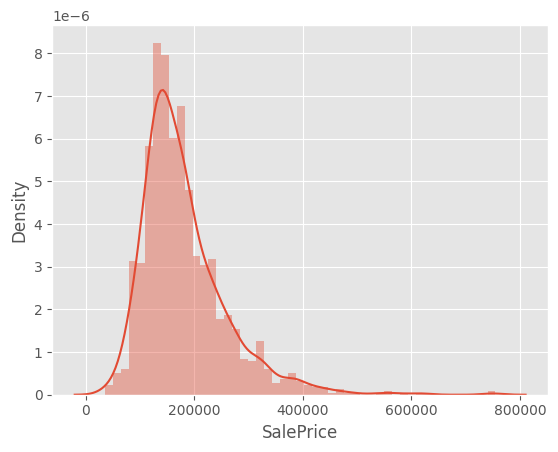

In [24]:
# 可视化展示'SalePrice'分布情况
# 画出概率密度图
sns.distplot(data['SalePrice'])
plt.show()

In [25]:
# 偏度skewness and 峰度kurtosis计算
# 偏度值离0越远，则越偏
print("Skewness: %f" % data['SalePrice'].skew())
print("Kurtosis: %f" % data['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


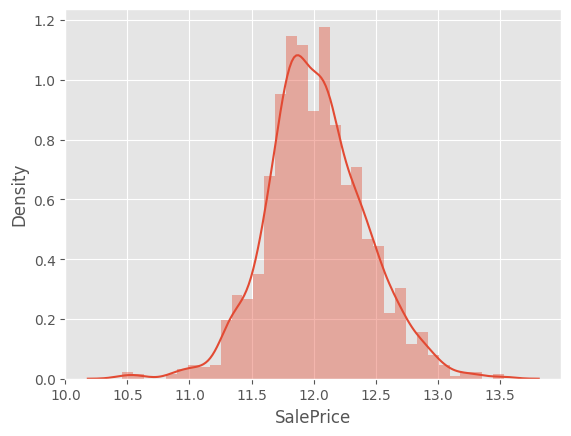

In [26]:
# 由上面结果可知，偏度大于0.75，则向左偏，采用ln（x+1）进行转化
data['SalePrice'] = np.log1p(data["SalePrice"])
# 画出概率密度图
sns.distplot(data['SalePrice'])
plt.show()

In [27]:
#转换后，偏度skewness and 峰度kurtosis计算
print("Skewness: %f" % data['SalePrice'].skew())
print("Kurtosis: %f" % data['SalePrice'].kurt())

Skewness: 0.121347
Kurtosis: 0.809519


In [28]:
# 删除基于SalePrice3倍标准差的异常值
data=data[np.abs(data['SalePrice']-data['SalePrice'].mean())<=(3*data['SalePrice'].std())]

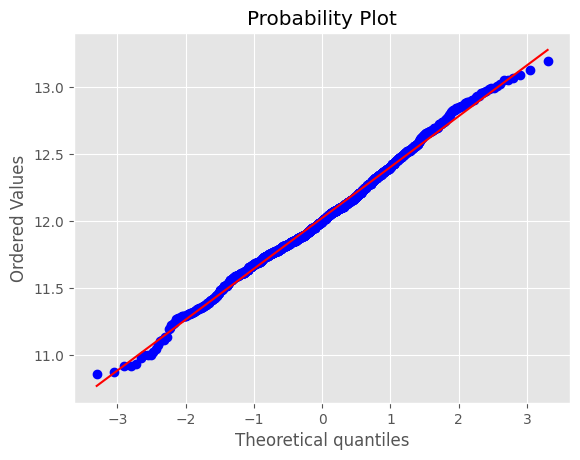

In [29]:
# 画qq图，该图斜率表示标准差，截距为均值，
# 查看SalePrice是否服从正态分布
# 越接近直线，越显正态性
res = stats.probplot(data['SalePrice'], plot=plt)

In [30]:
# 查看数据维度
data.shape

(1448, 73)

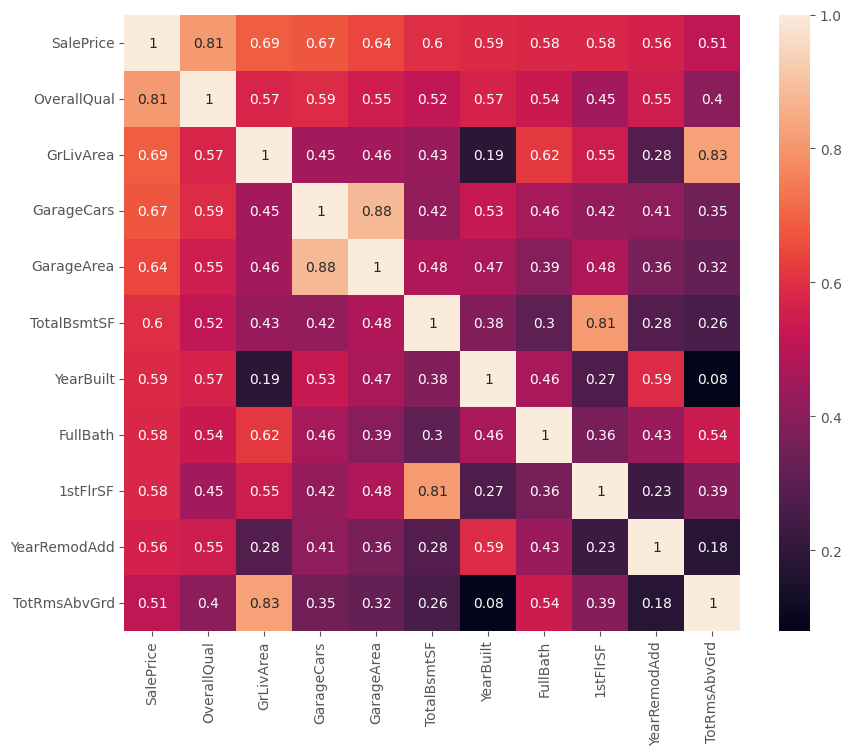

In [33]:
# 相关性分析
# 数值型数据分析
# 计算所有数值型特征与房价的相关系数

# 只保留数值型数据
numeric_data = data.select_dtypes(include=['number'])
corrmat = numeric_data.corr()
# 计算与房价相关性大于0.5的特征个数
k = len(corrmat[corrmat['SalePrice'] > 0.5].index)
# 获取前k个重要的特征名
cols = corrmat.nlargest(k,'SalePrice')['SalePrice'].index.tolist()
# 计算该k个特征的相关系数
cm = data[cols].corr()
# 画出可视化热图
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,square=True)
plt.show()

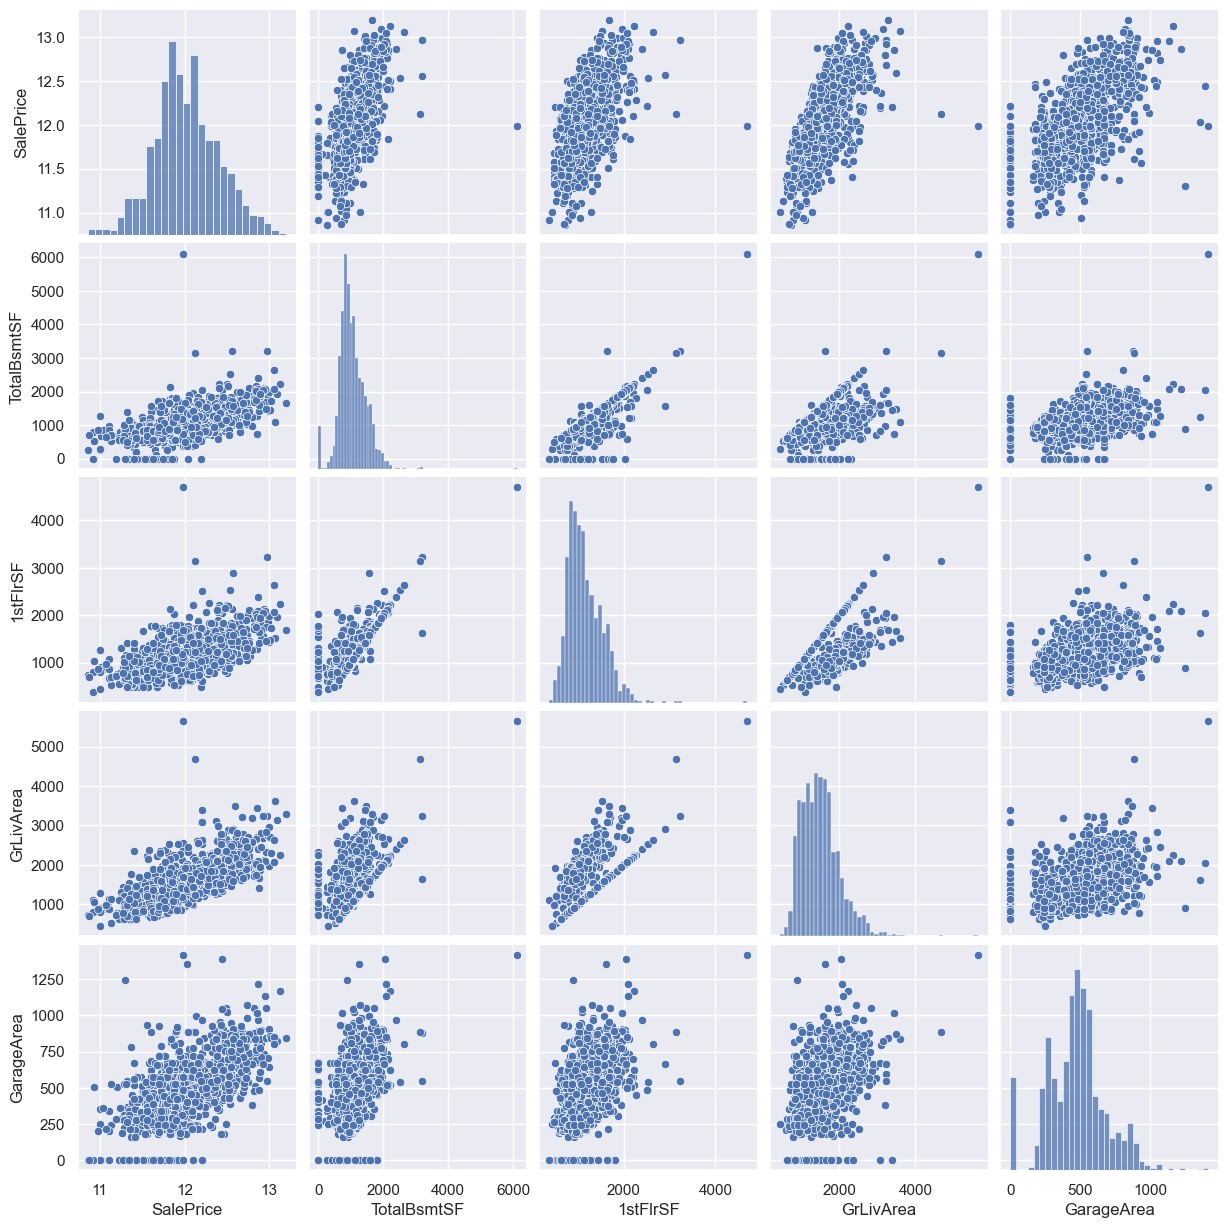

In [34]:
# 对面积特征画多变量图
sns.set()
area = ['SalePrice','TotalBsmtSF','1stFlrSF', 'GrLivArea', 'GarageArea']
sns.pairplot(data[area], size = 2.5)
plt.show()

In [35]:
# 由上图第一行后三个图可知基于'TotalBsmtSF','1stFlrSF', 'GrLivArea','GarageArea'
# 特征分别存在1、1、2、4个异常值，可剔除掉
data.drop(data[data['TotalBsmtSF'] > 4000].index, inplace=True)
data.drop(data[data['1stFlrSF'] > 4000].index, inplace=True)
data.drop(data[data['GrLivArea'] > 4000].index, inplace=True)
data.drop(data[data['GarageArea'] > 1240].index, inplace=True)

In [36]:
# 查看数据维度 
data.shape

(1443, 73)

In [37]:
# 分别计算'TotalBsmtSF','1stFlrSF', 'GrLivArea'，
#‘GarageArea'偏度skewness and 峰度kurtosis计算
print("Skewness: %f" % data['TotalBsmtSF'].skew())
print("Kurtosis: %f" % data['TotalBsmtSF'].kurt())
print("Skewness: %f" % data['1stFlrSF'].skew())
print("Kurtosis: %f" % data['1stFlrSF'].kurt())
print("Skewness: %f" % data['GrLivArea'].skew())
print("Kurtosis: %f" % data['GrLivArea'].kurt())
print("Skewness: %f" % data['GarageArea'].skew())
print("Kurtosis: %f" % data['GarageArea'].kurt())

Skewness: 0.414384
Kurtosis: 1.539572
Skewness: 0.867507
Kurtosis: 1.100841
Skewness: 0.820895
Kurtosis: 0.901041
Skewness: 0.022238
Kurtosis: 0.448625


In [38]:
# 将偏度大于0.75的'1stFlrSF', 'GrLivArea'进行ln(x + 1)
#转化生成新特征‘ln_1stFlrSF’和‘ln_GrLivArea’
data['ln_1stFlrSF'] = np.log1p(data["1stFlrSF"])
data['ln_GrLivArea'] = np.log1p(data["GrLivArea"])
print("Skewness: %f" % data['ln_1stFlrSF'].skew())
print("Kurtosis: %f" % data['ln_1stFlrSF'].kurt())
print("Skewness: %f" % data['ln_GrLivArea'].skew())
print("Kurtosis: %f" % data['ln_GrLivArea'].kurt())

Skewness: 0.022909
Kurtosis: -0.200772
Skewness: -0.059680
Kurtosis: -0.241430


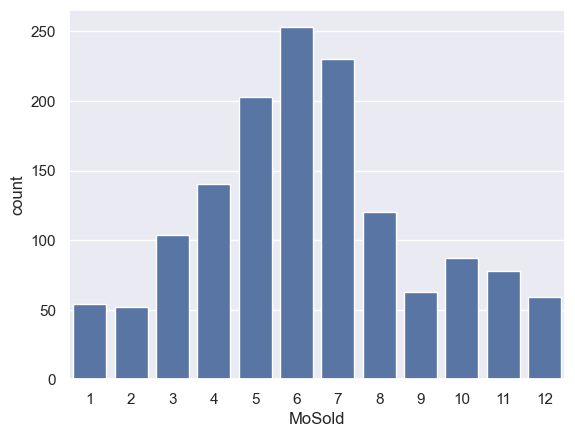

In [39]:
# 查看非线性特征，不同月份的房子的销售量
# 画出直方图，查看呈现规律
sns.countplot(x='MoSold',data=data)
plt.show()

In [40]:
# 查看数据特征类型, 即除SalePrice的列，有数值类型(numerical)和类别类型（category）
numeric = [f for f in data.drop(['SalePrice'], axis=1).columns 
           if data.drop(['SalePrice'], axis=1).dtypes[f] != 'object']
category = [f for f in data.drop(['SalePrice'], axis=1).columns 
            if data.drop(['SalePrice'], axis=1).dtypes[f] == 'object']
# 输出数值类型(numerical)特征个数，类型（category）特征个数
print("numeric: {}, category: {}" .format (len(numeric),len(category)))

numeric: 36, category: 38


In [41]:
# 对类别型数据做方差分析
# 定义方差函数，返回p-value值，其值越小对应特征越重要
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = category
    pvals = []
    for c in category:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        # stats.f_onewaym模块包由于计算p-value
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    # 将特征根据p-valu排序
    return anv.sort_values('pval')

# 将data带入定义的方差函数
a = anova(data)
# 输出a
a

,feature,pval
7,Neighborhood,2.348768e-237
16,ExterQual,8.553538e-194
28,KitchenQual,2.905300e-184
19,BsmtQual,6.686655e-184
32,GarageFinish,9.518461e-150
31,GarageYrBlt,1.216344e-143
30,GarageType,4.516320e-122
18,Foundation,1.642325e-109
25,HeatingQC,5.024923e-79
22,BsmtFinType1,4.325070e-76


In [42]:
# 重要数值型特征数据整合
# 用新的 df 构建数据集
# 选择相关性大于0.5的重要数值型特征
df = data[cols]
# 将 1stFlrSF 和 GrLivArea 特征ln(x+1)转化
df["1stFlrSF"] = data['ln_1stFlrSF']
df["GrLivArea"] = data['ln_GrLivArea']
# 将时间特征离散化，即没20年分段
df['YearBuilt'] = df['YearBuilt'].map(year_map)
df['YearRemodAdd'] = df['YearRemodAdd'].map(year_map)
# 对非线性特征 MoSold one-hot编码
month = pd.get_dummies(data['MoSold'],prefix='MoSold')
# 合并特征
df = pd.concat([df, month], axis=1)

In [43]:
# 对于类别型数据，跟据方差分析，选取排名重要的25个特征
features = a['feature'].tolist()[0:25]
# 合并特征
df = pd.concat([df, data[features]], axis=1)

In [44]:
# 查看特征维度
df.shape

(1443, 48)

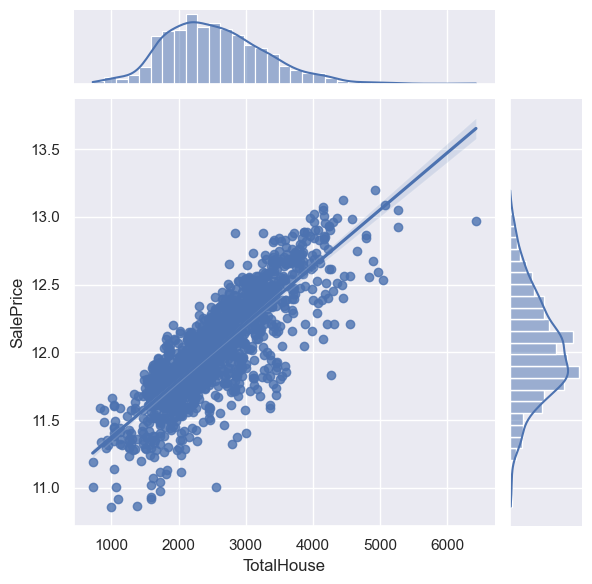

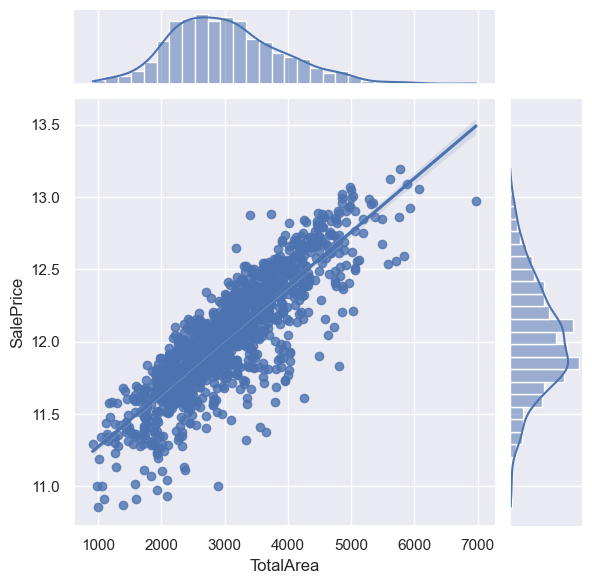

In [45]:
# 特征融合
# 将面积特征相加，构建总面积特征
df["TotalHouse"] = data["TotalBsmtSF"] + data["1stFlrSF"] + data["2ndFlrSF"]
df["TotalArea"]=data["TotalBsmtSF"]+data["1stFlrSF"]+data["2ndFlrSF"]+data["GarageArea"]
# 画出其回归图
sns.jointplot(x=df["TotalHouse"], y=df['SalePrice'], data = df, kind="reg")
sns.jointplot(x=df["TotalArea"], y=df['SalePrice'], data = df, kind="reg")
plt.show()

In [46]:
# 由图可知融合的特征较好，TotalHouse、TotalArea分别含有1个异常,可将其剔除掉
df.drop(df[df['TotalHouse'] > 6000].index, inplace=True)
df.drop(df[df['TotalArea'] > 6500].index, inplace=True)

In [47]:
# 继续融合特征
# 将部分相关联的特征进行相加或相乘
df["+_TotalHouse_OverallQual"] = df["TotalHouse"] * data["OverallQual"]
df["+_GrLivArea_OverallQual"] = data["GrLivArea"] * data["OverallQual"]
df["+_BsmtFinSF1_OverallQual"] = data["BsmtFinSF1"] * data["OverallQual"]
df["-_LotArea_OverallQual"] = data["LotArea"] * data["OverallQual"]
df["-_TotalHouse_LotArea"] = df["TotalHouse"] + data["LotArea"]
df["Bsmt"] = data["BsmtFinSF1"] + data["BsmtFinSF2"] + data["BsmtUnfSF"]
df["Rooms"] = data["FullBath"]+data["TotRmsAbvGrd"] 
df["PorchArea"] = data["OpenPorchSF"] + data["EnclosedPorch"] + data["3SsnPorch"] + data["ScreenPorch"]
# \ 表示换行
df["TotalPlace"] = df["TotalBsmtSF"] + data["1stFlrSF"] + data["2ndFlrSF"] + data["GarageArea"] + \
                   data["OpenPorchSF"] + data["EnclosedPorch"]+ data["3SsnPorch"] + data["ScreenPorch"]

In [48]:
# 将所有的类别型特征，one-hot编码
df = pd.get_dummies(df)
# 查看数据维度
df.shape

(1442, 217)

In [49]:
# 构建模型
# 导入GBDT算法
from sklearn.ensemble import GradientBoostingRegressor
# 导入均方误差计算
from sklearn.metrics import mean_squared_error
# 导入标准化模块包
from sklearn.preprocessing import RobustScaler
# 导入划分数据集包，交叉验证包
from sklearn.model_selection import train_test_split,KFold,cross_val_score
# 导入Xgboost算法包
import xgboost as xgb

In [50]:
# 特征标准化
x = RobustScaler().fit_transform(df.drop(['SalePrice'], axis=1).values)
# 提取标签
y = df['SalePrice'].values

In [51]:
# 定义验证函数,使用5折交叉验证，采用均方根误差判别，返回均方根误差
def rmse_cv(model):
    # 将数据集shuffle打乱，划分成五分
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    # 计算均方根误差，其输出结果有五个
    rmse= np.sqrt(-cross_val_score(model,x,y,scoring="neg_mean_squared_error",cv = kf))
    return rmse

In [52]:
# GBDT算法
# 使用GBDT算法，构建模型
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.005,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score1 = rmse_cv(GBoost)
# 输出五个均方根误差的平均值RSME和其标准差SD,保留4位小数
print("Gradient Boosting score: RSME={:.4f} (SD={:.4f})\n".format(score1.mean(),score1.std()))

Gradient Boosting score: RSME=0.1136 (SD=0.0115)



In [53]:
# Xgboost算法
# Xgboost算法,构建模型
Xgboost = xgb.XGBRegressor(colsample_bytree=0.36, gamma=0.042, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.88, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state = 1, nthread = -1)
score2 = rmse_cv(Xgboost)
# 输出五个均方根误差的平均值RSME和其标准差SD,保留4位小数
print("Xgboost score: RSME={:.4f} (SD={:.4f})\n".format(score2.mean(),score2.std()))

Xgboost score: RSME=0.1165 (SD=0.0106)



In [56]:
# 将80%数据作为训练集，20%数据作为测试集
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)
# 定义回归拟合图,以预测值输入
def drawing(y_hat):
    # 获取预测的测试集从小到大排序的索引
    order = np.argsort(y_hat)
    # 将测试集和预测的测试集按索引排序
    y_test_new = y_test[order]
    y_hat = y_hat[order]
    # 画图展示
    plt.figure(figsize=(8, 6),facecolor='w')
    t = np.arange(len(y_test))
    plt.plot(t, y_test_new, 'b-', linewidth=2, label='True')
    plt.plot(t, y_hat, 'r-', linewidth=2, label='Predicted')
    plt.legend(loc='upper left')
    plt.grid(visible=True)
    plt.show()

RMSE =  0.0983
R2_train = 0.9487
R2_test = 0.9275


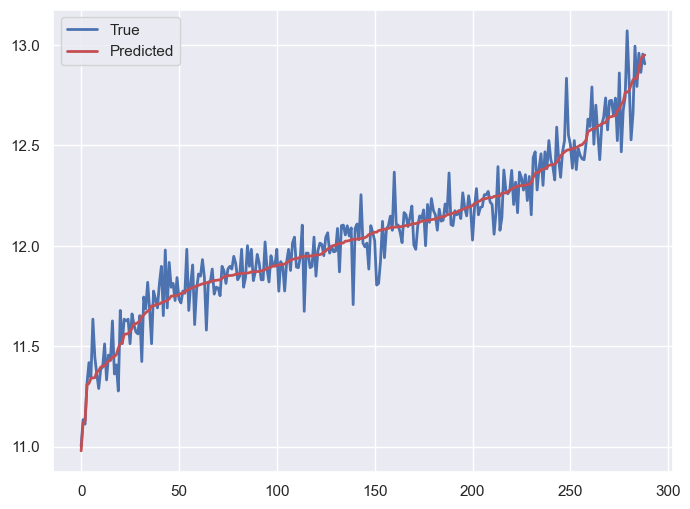

In [57]:
# 使用GBDT算法，构建模型
# 训练集训练
GBoost.fit(x_train, y_train)
# 测试集结果预测
y_hat1 = GBoost.predict(x_test)
# 分别输出均方根误差RMSE，训练集和测试集的拟合优度R2
print("RMSE =  %.4f" % np.sqrt(np.mean((y_hat1 - y_test) ** 2)))
print('R2_train = %.4f' % GBoost.score(x_train, y_train))
print('R2_test = %.4f' % GBoost.score(x_test, y_test))
# 画出拟合效果图，蓝色表示真实值，红色为预测值
drawing(y_hat1)

RMSE =  0.1042
R2_train = 0.9487
R2_test = 0.9275


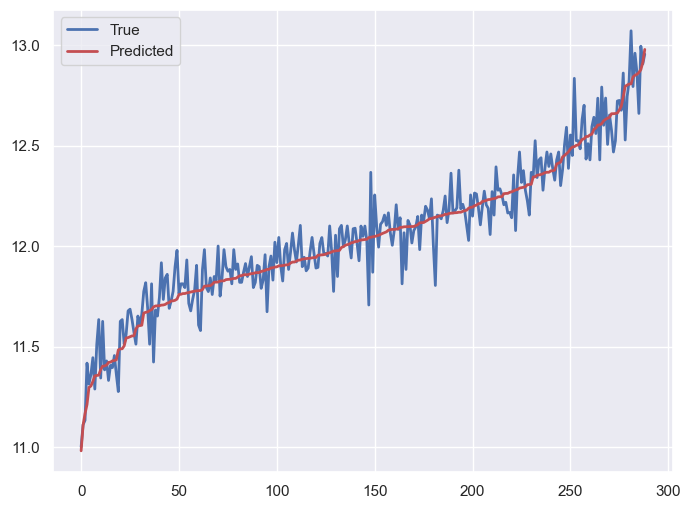

In [58]:
# 使用Xgboost算法，构建模型
# 训练集训练
Xgboost.fit(x_train, y_train)
# 测试集结果预测
y_hat2 = Xgboost.predict(x_test)
# 分别输出均方根误差RMSE，训练集和测试集的拟合优度R2
print("RMSE =  %.4f" % np.sqrt(np.mean((y_hat2 - y_test) ** 2)))
print('R2_train = %.4f' % GBoost.score(x_train, y_train))
print('R2_test = %.4f' % GBoost.score(x_test, y_test))
# 画出拟合效果图 ，蓝色表示真实值，红色为预测值
drawing(y_hat2)